In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
root = "./data/"

In [3]:
sales_train = pd.read_csv(root + "sales_train.csv")
items = pd.read_csv(root + "items.csv")
shops = pd.read_csv(root + "shops.csv")
item_categories = pd.read_csv(root + "item_categories.csv")
test = pd.read_csv(root + "test.csv")
sample_submission = pd.read_csv(root + "sample_submission.csv")

## Let's have a looks at the data

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## EDA

In [10]:
print(f"Transactions: {len(sales_train):,}")

Transactions: 2,935,849


In [11]:
print(f"Transaction dates: From {sales_train['date'].min()} to {sales_train['date'].max()}")

Transaction dates: From 01.01.2013 to 31.12.2014


In [12]:
# group by day
sales_train = pd.read_csv(root + "sales_train.csv", parse_dates=['date'])
group = sales_train.groupby(['date']).agg(['sum', 'count']).reset_index()
print(f"from {group['item_cnt_day']['count'].min():,} to {group['item_cnt_day']['count'].max():,} transactions per day")
print(f"from {group['item_cnt_day']['sum'].min():,} to {group['item_cnt_day']['sum'].max():,} items bought daily")

from 1,123 to 9,434 transactions per day
from 1,274.0 to 13,343.0 items bought daily


In [13]:
# group by month
group = sales_train.groupby(sales_train.date.dt.to_period("M")).agg(['sum', 'count']).reset_index()
print(f"from {group['item_cnt_day']['count'].min():,} to {group['item_cnt_day']['count'].max():,} transactions per month")
print(f"from {group['item_cnt_day']['sum'].min():,} to {group['item_cnt_day']['sum'].max():,} items bought per month")

from 18,252 to 144,640 transactions per month
from 21,484.0 to 184,559.0 items bought per month


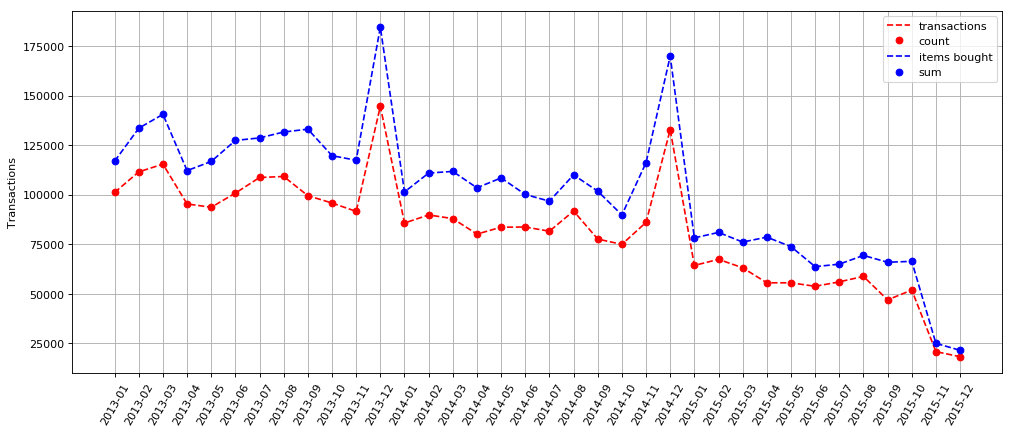

In [14]:
# group by month
group = sales_train.groupby(sales_train.date.dt.to_period("M")).agg(['sum', 'count']).reset_index()

group_sorted = group.sort_values(by=['date'])

fig, ax = plt.subplots(1,1, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
x = np.arange(0,len(group_sorted),1)
ax.plot(x, group_sorted['item_cnt_day']['count'], 'r--', label='transactions')
ax.plot(x, group_sorted['item_cnt_day']['count'], 'ro')

ax.set_ylabel('Transactions')

ax.plot(x, group_sorted['item_cnt_day']['sum'], 'b--', label='items bought')
ax.plot(x, group_sorted['item_cnt_day']['sum'], 'bo')
ax.set_xticks(x)
ax.set_xticklabels(group_sorted['date'], rotation=60)
ax.grid()

ax.legend()

plt.show()

Items per day count distributions. Using this we can see some outliers and remove them later.

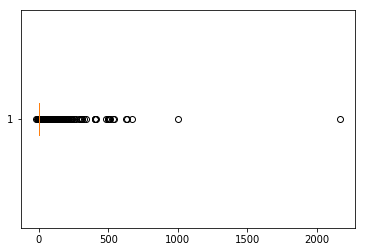

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.boxplot(sales_train['item_cnt_day'],vert=False, whis=0.75);

Items prices distributions. Using this we can see some outliers and remove them later.

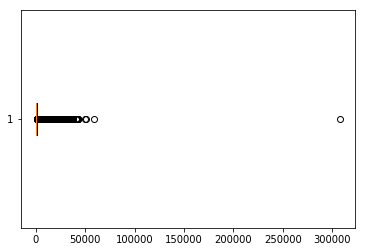

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.boxplot(sales_train['item_price'],vert=False, whis=0.75);

From above looks like we have negative prices

In [21]:
print(f"count(item_price < 0) = {len(sales_train[sales_train['item_price'] < 0])}")

count(item_price < 0) = 1


In [22]:
max_item_cnt = 800
max_item_price = 8000

In [34]:
shops_group = shops.groupby(by=['shop_name']).count().reset_index()
dubled_shop_names = shops_group[shops_group['shop_id'] > 1]['shop_name']
print(f"Doubled shop names = {len(dubled_shop_names)}")

Doubled shop names = 0


# Preprocess data

In [63]:
sales_train = pd.read_csv(root + "sales_train.csv")


sales_train = sales_train[sales_train.item_price<max_item_price]
sales_train = sales_train[sales_train.item_cnt_day<max_item_cnt]

[z_shop, z_item, z_date] = sales_train[sales_train['item_price'] < 0][['shop_id', 'item_id', 'date_block_num']].values[0]
z_median_price = sales_train[(sales_train.shop_id==z_shop)&(sales_train.item_id==z_item)&(sales_train.date_block_num==z_date)&(sales_train.item_price>0)]['item_price'].median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = z_median_price

Let's group all data by (date_block_num, shop_id, item_id). But we can't just group it by this date, because model wouldn't take into consideration missing data. But missing data would actually mean that this item into shop had no sales.

For this I firstly created dataset with all unique combinations of item/shop/date_block_num and after filled this data from sales_train data.

In [6]:
from itertools import product

def allUniqueCombinations(block_num, shops, items):
    return np.array([*product([block_num],shops,items)])
    
sales_items_pre = []
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    shops_ = sales['shop_id'].unique()
    items_ = sales['item_id'].unique()
    res = allUniqueCombinations(i,shops_,items_)
    sales_items_pre.append(res)
    
sales_items_pre = pd.DataFrame(np.vstack(sales_items_pre), columns=['date_block_num','shop_id','item_id'])
sales_items_pre = sales_items_pre.sort_values(['date_block_num','shop_id','item_id'])

Group by month, because in test datgaset we have only month info.

Create new field item_cnt_month

In [7]:
sales_train_by_month = sales_train\
    .groupby(['date_block_num','shop_id','item_id'])\
    .agg({'item_cnt_day': 'sum'})\
    .reset_index()\
    .rename(columns={ 'item_cnt_day': 'item_cnt_month' })

sales_train = pd.merge(sales_items_pre, sales_train_by_month, on=['date_block_num','shop_id','item_id'], how='left')

Set date_block_num=34 for test dataset. - because that's next month after last one 33'th.

Merge sales_train with test dataset. We do this to preprocess and generate features for train/valid/test datasets into same time

Fill all missing data (NaN's) with 0. because missing data means no sales.

In [8]:
test['date_block_num'] = 34

sales_train = pd.concat([sales_train, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
sales_train = sales_train.fillna(0)
sales_train = sales_train.drop(columns=['ID'])

In [9]:
sales_train.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


## Feature creation

Month of the year

In [10]:
sales_train['month'] = sales_train['date_block_num'] % 12

sales_train = pd.merge(sales_train, items, how='left', on='item_id')
sales_train = pd.merge(sales_train, shops, how='left', on='shop_id')
# remove extra field
sales_train = sales_train.drop(columns=['item_name'])

Helper functions:
1. addLaggFeature - create lagging features. This features represents some feature values in previous periods. For example 1,2,3,6,12 months ago. This is usefull for timeseries when we know that there is some correlation with time
2. lagFeatureCombinations - create meanencoding feature based on some set of categories and use addLaggFeature for this feature.

In [11]:
def addLaggFeature(sales_train, colName, lags):
    res = sales_train.copy()
    for lag in lags:
        # create copy of df
        group_shifted = res.copy()
        # change it's date_block_num by lag
        group_shifted['date_block_num'] = group_shifted['date_block_num'] + lag
        group_shifted = group_shifted[['date_block_num','shop_id','item_id', colName]]
        group_shifted.columns = ['date_block_num','shop_id','item_id', f"{colName}_lag_{lag}"]
        # merge by date_block_num
        res = pd.merge(res, group_shifted, on=['date_block_num','shop_id','item_id'] ,how='left')
    return res

def lagFeatureCombinations(sales_train, features=['date_block_num'], lags=[1], targetLagging='item_cnt_month', op='mean'):
    new_col_name = '_'.join(features) + '__' + targetLagging
    group = sales_train.groupby(features).agg({targetLagging: op}).reset_index().rename(columns={ targetLagging: new_col_name })
    sales_train = pd.merge(sales_train, group, on=features, how='left')
    sales_train = addLaggFeature(sales_train, new_col_name, lags)
    # We stay only lagging features
    sales_train = sales_train.drop(columns=[new_col_name])
    return sales_train

Create lagging features for item_cnt_month column.

item_cnt_month_lag_1, item_cnt_month_lag_2, item_cnt_month_lag_3, item_cnt_month_lag_6, item_cnt_month_lag_12 - features created. They represents what was the item_cnt_month value for selected item 1,2,3,6,12 months

In [12]:
sales_train = addLaggFeature(sales_train, 'item_cnt_month', [1,2,3,6,12])
sales_train[sales_train['date_block_num'] > 12].head()

,date_block_num,shop_id,item_id,item_cnt_month,month,item_category_id,shop_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
4836056,13,2,30,0.0,1,40,"Адыгея ТЦ ""Мега""",0.0,0.0,0.0,0.0,0.0
4836057,13,2,31,0.0,1,37,"Адыгея ТЦ ""Мега""",0.0,0.0,0.0,0.0,4.0
4836058,13,2,32,0.0,1,40,"Адыгея ТЦ ""Мега""",1.0,0.0,0.0,0.0,0.0
4836059,13,2,33,0.0,1,37,"Адыгея ТЦ ""Мега""",1.0,1.0,2.0,0.0,0.0
4836060,13,2,34,0.0,1,40,"Адыгея ТЦ ""Мега""",0.0,0.0,0.0,0.0,0.0


Shop_name column has interesting pattern. Its value can be represented as "{city} {shop_name}" formula. let's extract these values.

In [13]:
# 1 shop has exception into filename
sales_train.loc[sales_train.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'Сергиев-Посад ТЦ "7Я"'
# split by " "
shop_name_split = sales_train['shop_name'].str.split(' ', n=2, expand = True)

sales_train['city'] = shop_name_split[0]
sales_train['shop_full_name'] = sales_train['shop_name']
sales_train['shop_name'] = shop_name_split[1]

Item category names also has a pattern. It can be represented as "{type1} {type2}" where type1 is a category type and type2 - sub_category.

In [14]:
sales_train = pd.merge(sales_train, item_categories, how='left', on=['item_category_id'])

category_split = sales_train['item_category_name'].str.split('-', n=2, expand = True)
sales_train['item_category_type'] = category_split[0]

Mean encoding + lagging.

Here I'm making advanced features. I group data by different categorical features, calculate mean value for item_cnt_month and add lagging fields for this mean field.

This gives to the model good time series representation for a row.

In [15]:
import gc
del sales_items_pre
del category_split
del shop_name_split
del sales_train_by_month
gc.collect()

12

In [16]:
import time
ts = time.time()
done = 0
def times():
    global done
    done = done + 1
    return done

all_year_lags = [1,3,6,12]

sales_train = lagFeatureCombinations(sales_train, features=['date_block_num'])
print(f"{times()} - {time.time() - ts}")
sales_train = lagFeatureCombinations(sales_train, features=['date_block_num', 'item_id'], lags=all_year_lags)
print(f"{times()} - {time.time() - ts}")
sales_train = lagFeatureCombinations(sales_train, features=['date_block_num', 'shop_id'], lags=all_year_lags)
print(f"{times()} - {time.time() - ts}")
sales_train = lagFeatureCombinations(sales_train, features=['date_block_num', 'item_category_id'],)
print(f"{times()} - {time.time() - ts}")
sales_train = lagFeatureCombinations(sales_train, features=['date_block_num', 'shop_id', 'item_category_id'],)
print(f"{times()} - {time.time() - ts}")
sales_train = lagFeatureCombinations(sales_train, features=['date_block_num', 'shop_id', 'item_category_type'],)
print(f"{times()} - {time.time() - ts}")
sales_train = lagFeatureCombinations(sales_train, features=['date_block_num', 'city'],)
print(f"{times()} - {time.time() - ts}")
sales_train = lagFeatureCombinations(sales_train, features=['date_block_num', 'item_id', 'city'],)
print(f"{times()} - {time.time() - ts}")
sales_train = lagFeatureCombinations(sales_train, features=['date_block_num', 'item_category_type'],)
print(f"{times()} - {time.time() - ts}")

sales_train[sales_train['date_block_num'] > 11].head()

1 - 46.70690894126892
2 - 153.60261416435242
3 - 271.69831919670105
4 - 317.74946808815
5 - 365.23693919181824
6 - 417.2538890838623
7 - 472.48725724220276
8 - 533.2159559726715
9 - 588.2421650886536


,date_block_num,shop_id,item_id,item_cnt_month,month,item_category_id,shop_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,...,date_block_num_shop_id__item_cnt_month_lag_1,date_block_num_shop_id__item_cnt_month_lag_3,date_block_num_shop_id__item_cnt_month_lag_6,date_block_num_shop_id__item_cnt_month_lag_12,date_block_num_item_category_id__item_cnt_month_lag_1,date_block_num_shop_id_item_category_id__item_cnt_month_lag_1,date_block_num_shop_id_item_category_type__item_cnt_month_lag_1,date_block_num_city__item_cnt_month_lag_1,date_block_num_item_id_city__item_cnt_month_lag_1,date_block_num_item_category_type__item_cnt_month_lag_1
4488710,12,2,27,0.0,0,19,ТЦ,0.0,0.0,0.0,...,0.156025,0.098893,0.096014,0.14122,1.181682,0.965636,0.814706,0.156025,0.0,1.125096
4488711,12,2,30,0.0,0,40,ТЦ,0.0,0.0,0.0,...,0.156025,0.098893,0.096014,NaN,0.309148,0.046246,0.051719,0.156025,0.0,0.281054
4488712,12,2,31,0.0,0,37,ТЦ,0.0,0.0,0.0,...,0.156025,0.098893,0.096014,NaN,0.234054,0.059459,0.051719,0.156025,0.0,0.281054
4488713,12,2,32,1.0,0,40,ТЦ,0.0,0.0,0.0,...,0.156025,0.098893,0.096014,0.14122,0.309148,0.046246,0.051719,0.156025,0.0,0.281054
4488714,12,2,33,1.0,0,37,ТЦ,1.0,2.0,0.0,...,0.156025,0.098893,0.096014,0.14122,0.234054,0.059459,0.051719,0.156025,1.0,0.281054


Let's look at the dataset know

In [18]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 31 columns):
 #   Column                                                           Dtype  
---  ------                                                           -----  
 0   date_block_num                                                   int64  
 1   shop_id                                                          int64  
 2   item_id                                                          int64  
 3   item_cnt_month                                                   float64
 4   month                                                            int64  
 5   item_category_id                                                 int64  
 6   shop_name                                                        object 
 7   item_cnt_month_lag_1                                             float64
 8   item_cnt_month_lag_2                                             float64
 9   item_cnt_month_lag_3  

Encode string values. Shop name, category name, etc..

In [19]:
sales_train['shop_name'] = LabelEncoder().fit_transform(sales_train['shop_name'])
sales_train['city'] = LabelEncoder().fit_transform(sales_train['city'])
sales_train['shop_full_name'] = LabelEncoder().fit_transform(sales_train['shop_full_name'])
sales_train['item_category_name'] = LabelEncoder().fit_transform(sales_train['item_category_name'])
sales_train['item_category_type'] = LabelEncoder().fit_transform(sales_train['item_category_type'])

As the max value for lagging was 12. That make no sense for using data that had not at least 1 year of history.

So I basically cut att data before 11 date_block_num

And fill NaN values with zeros

In [20]:
sales_train = sales_train[sales_train['date_block_num'] > 11]
sales_train = sales_train.fillna(0)

In [21]:
sales_train.to_pickle('sales_train.pkl')

In [2]:
import pandas as pd
sales_train = pd.read_pickle('sales_train.pkl')

Test/val split

In [22]:
def trainTestSplit(sales_train):
    y_column = 'item_cnt_month'
    x_cols = sales_train.columns.values[sales_train.columns.values != y_column]
    test_date_block_num = 33

    train_df = sales_train[sales_train['date_block_num'] < test_date_block_num]
    test_df = sales_train[sales_train['date_block_num'] == test_date_block_num]

    return ((train_df[x_cols], train_df[y_column]), (test_df[x_cols], test_df[y_column]))

In [23]:
((X_train, y_train), (X_test, y_test)) = trainTestSplit(sales_train)

X_train = X_train.drop(columns=['date_block_num'])
X_test = X_test.drop(columns=['date_block_num'])

print(f"X_train = {X_train.shape}")
print(f"y_train = {y_train.shape}")
print(f"X_test  = {X_test.shape}")
print(f"y_test  = {y_test.shape}")

X_train = (6186922, 29)
y_train = (6186922,)
X_test  = (238172, 29)
y_test  = (238172,)


## Model

I used XGBRegressor model. XgBoost build decision trees each based on limited categories each.

And XGBRegressor because task we are solving is basically regression.

Parameters were tunned manually without grid search or somiliar tools. I just used recommended parameters from the web ;)

Optimized parameter is RMSE

In [26]:
from xgboost import XGBRegressor
import time

ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=200,
    min_child_weight=8, 
    colsample_bytree=0.9, 
    subsample=0.9, 
    eta=0.25)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts


[0]	validation_0-rmse:1.15504	validation_1-rmse:1.12395
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1122	validation_1-rmse:1.09311
[2]	validation_0-rmse:1.07465	validation_1-rmse:1.06668
[3]	validation_0-rmse:1.04326	validation_1-rmse:1.04446
[4]	validation_0-rmse:1.01606	validation_1-rmse:1.02567
[5]	validation_0-rmse:0.993152	validation_1-rmse:1.01051
[6]	validation_0-rmse:0.974069	validation_1-rmse:0.997706
[7]	validation_0-rmse:0.95752	validation_1-rmse:0.987514
[8]	validation_0-rmse:0.942231	validation_1-rmse:0.976281
[9]	validation_0-rmse:0.929654	validation_1-rmse:0.966856
[10]	validation_0-rmse:0.919463	validation_1-rmse:0.96114
[11]	validation_0-rmse:0.910269	validation_1-rmse:0.955171
[12]	validation_0-rmse:0.902099	validation_1-rmse:0.950399
[13]	validation_0-rmse:0.895039	validation_1-rmse:0.946585
[14]	validation_0-rmse:0.889387	valida

In [ ]:
X_submit = sales_train[sales_train['date_block_num'] == 34]
X_submit = X_submit.drop(columns=['item_cnt_month','date_block_num'])

In [ ]:
predicts = model.predict(X_submit)

In [ ]:
sample_submission.head()

In [ ]:
submit = sample_submission.copy()
submit['item_cnt_month'] = predicts
submit = submit.set_index('ID')
submit.to_csv('submit.csv')

In [ ]:
sales_train.to_pickle('sales_train.pkl')